In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline

def print_score(y_pred, y_real, y_score, label_encoder, model_name):

    data = []

    data.append(["Accuracy", accuracy_score(y_real, y_pred)])
    data.append(["Precision (macro)", precision_score(y_real, y_pred, average='macro', zero_division=1)])
    data.append(["Recall (macro)", recall_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["F1-score (macro)", f1_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["AUC-ROC (macro)", roc_auc_score(y_real, y_score, multi_class='ovr', average='macro')])

    for i in range(len(label_encoder.classes_)):
        class_name = label_encoder.inverse_transform([i])[0]
        data.append([f"Precision ({class_name})", precision_score(y_real, y_pred, labels=[i], average='weighted', zero_division=1)])
        data.append([f"Recall ({class_name})", recall_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])
        data.append([f"F1-score ({class_name})", f1_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])

    score_df = pd.DataFrame(data, columns=["Metric", "Value"])
    display(score_df)

    # Save the score DataFrame to a CSV file
    score_df.to_csv(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_metrics.csv", index=False)


def plot_roc_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    print(f"Number of classes: {n_classes}")
    print(f"Shape of y_score: {y_score.shape}")

    # Handle the case where y_score has fewer columns than expected
    if y_score.shape[1] != n_classes:
        print("Fixing y_score shape")
        diff = n_classes - y_score.shape[1]
        y_score = np.hstack((y_score, np.zeros((y_score.shape[0], diff))))

    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show()
        plt.show()
    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 6))
        for i in range(n_classes):
            class_name = label_encoder.inverse_transform([i])[0]
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()


from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
        average_precision = average_precision_score(y_true, y_score[:, 1])

        plt.figure(figsize=(10, 6))  # Change the figure size here
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()
    else:
        y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i], average=None)

        # Plot Precision-Recall curve for each class
        plt.figure(figsize=(10, 6))  # Change the figure size here
        for i in range(n_classes):
            disp = PrecisionRecallDisplay(precision=precision[i], recall=recall[i])
            class_name = label_encoder.inverse_transform([i])[0]
            disp.plot(ax=plt.gca(), label='Precision-recall curve of class {0} (AP = {1:0.2f})'.format(class_name, average_precision[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()

def plot_class_accuracy(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    class_counts = np.zeros(n_classes)
    class_corrects = np.zeros(n_classes)

    for t, p in zip(y_true, y_pred):
        class_counts[t] += 1
        if t == p:
            class_corrects[t] += 1

    class_accuracies = class_corrects / class_counts
    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_class_accuracy.png", bbox_inches='tight')  # Move this line before plt.show()
    plt.show()

def plot_class_f1_score(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    f1_scores = []

    for i in range(n_classes):
        class_f1_score = f1_score(y_true, y_pred, labels=[i], average='weighted')
        f1_scores.append(class_f1_score)

    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores)
    plt.xlabel('Class')
    plt.ylabel('F1-score')
    plt.title('F1-score per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    fig = plt.gcf()  # Get the current figure
    plt.show()

    # Save the figure to an image file
    fig.savefig(f"/content/drive/MyDrive/Results/{model_name}_EdgeIIoT_class_f1_score.png", bbox_inches='tight')

# Load the dataset
file_path = '/content/drive/MyDrive/Data/preprocessed_EdgeIIoT.csv'


df = pd.read_csv(file_path)


Number of classes: 15
Shape of y_score: (30447, 15)


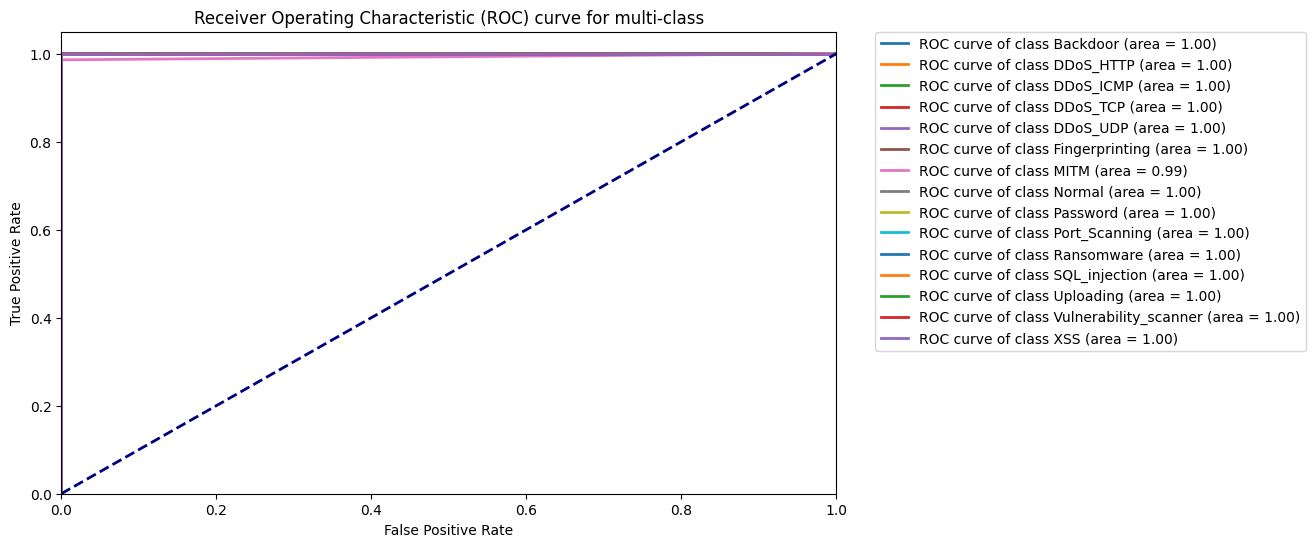

DecisionTree Classifier


,Metric,Value
0,Accuracy,0.999934
1,Precision (macro),0.999587
2,Recall (macro),0.999051
3,F1-score (macro),0.999315
4,AUC-ROC (macro),0.999523
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),1.000000
7,F1-score (Backdoor),1.000000
8,Precision (DDoS_HTTP),1.000000
9,Recall (DDoS_HTTP),1.000000


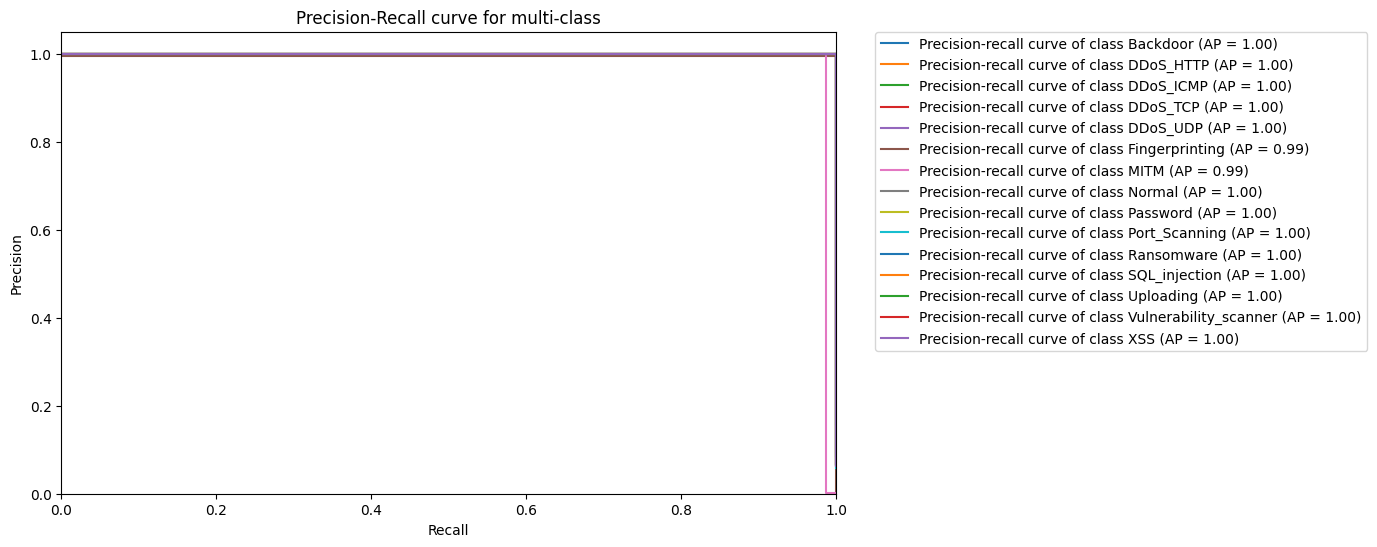

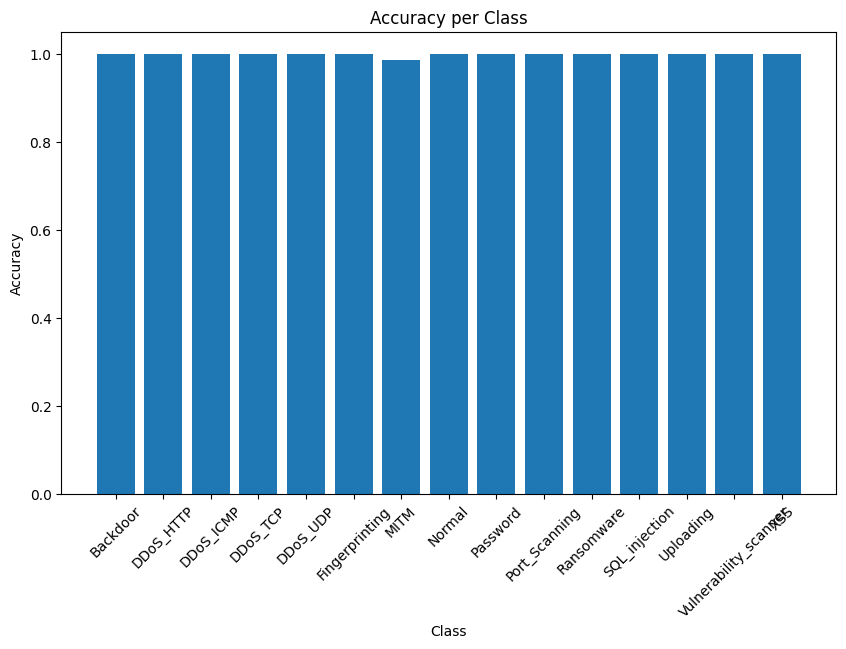

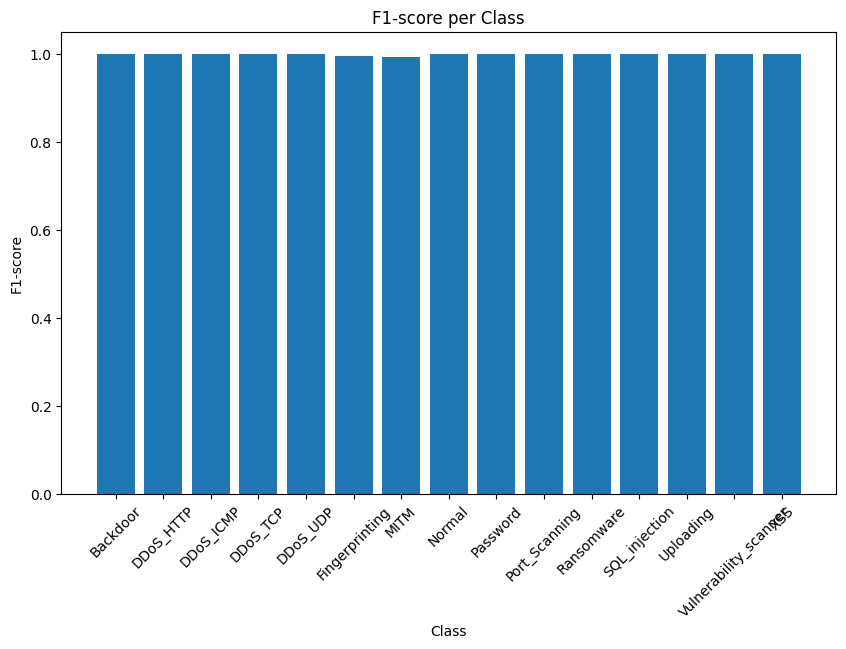

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier


# Encode the labels
le = LabelEncoder()
df['Attack_type'] = le.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']
# Encode the target variable

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Get prediction scores
y_score = dt_classifier.predict_proba(X_test)

# Assume plot_roc_curve, print_score, plot_precision_recall_curve, plot_class_accuracy and plot_class_f1_score are defined functions
model_name = 'DecisionTree'
plot_roc_curve(y_test, y_score, le, model_name)

# Print scores
print("DecisionTree Classifier")
print_score(y_pred, y_test, y_score, le, model_name)
plot_precision_recall_curve(y_test, y_score, le, model_name)
plot_class_accuracy(y_test, y_pred, le, model_name)
plot_class_f1_score(y_test, y_pred, le, model_name)


Number of classes: 15
Shape of y_score: (30447, 15)


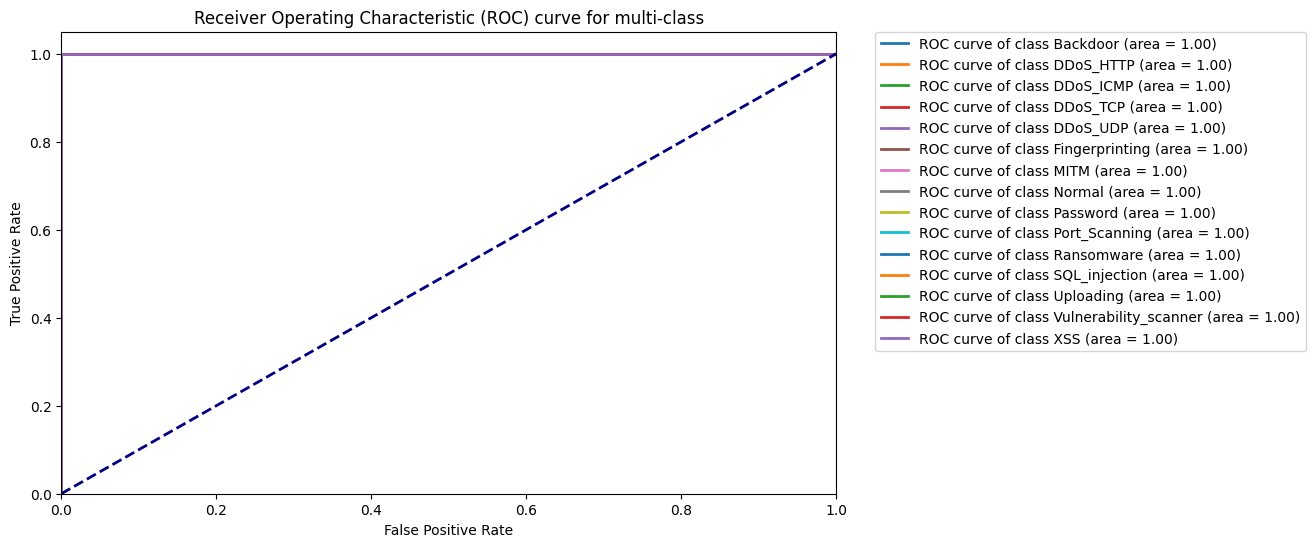

LogisticRegression Classifier


,Metric,Value
0,Accuracy,1.0
1,Precision (macro),1.0
2,Recall (macro),1.0
3,F1-score (macro),1.0
4,AUC-ROC (macro),1.0
5,Precision (Backdoor),1.0
6,Recall (Backdoor),1.0
7,F1-score (Backdoor),1.0
8,Precision (DDoS_HTTP),1.0
9,Recall (DDoS_HTTP),1.0


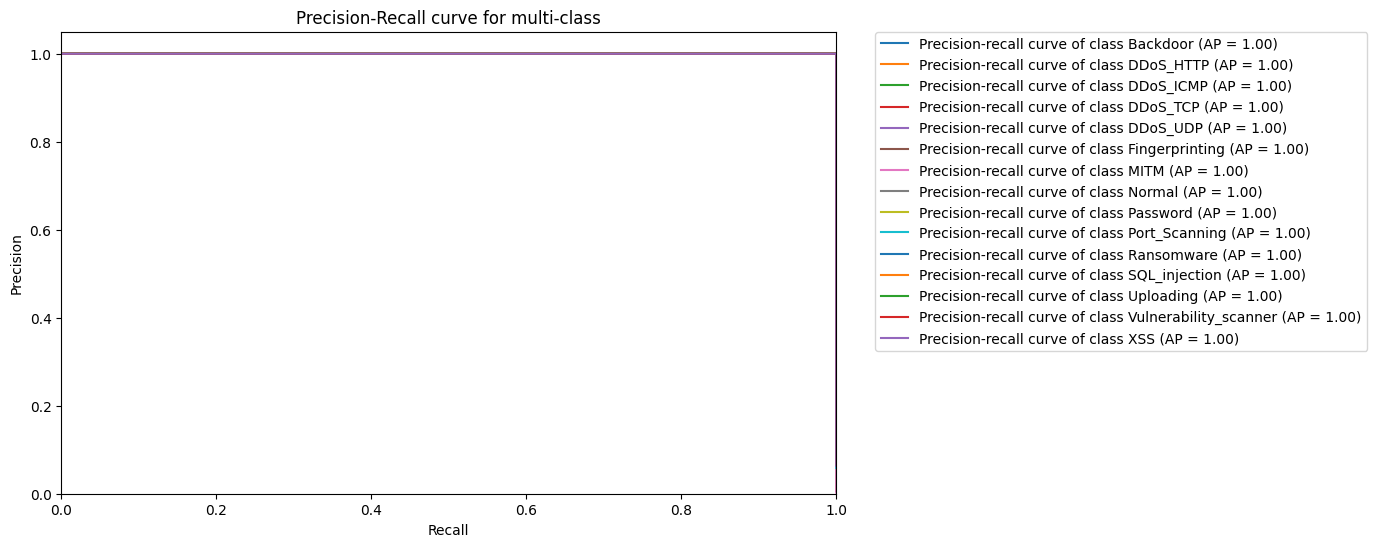

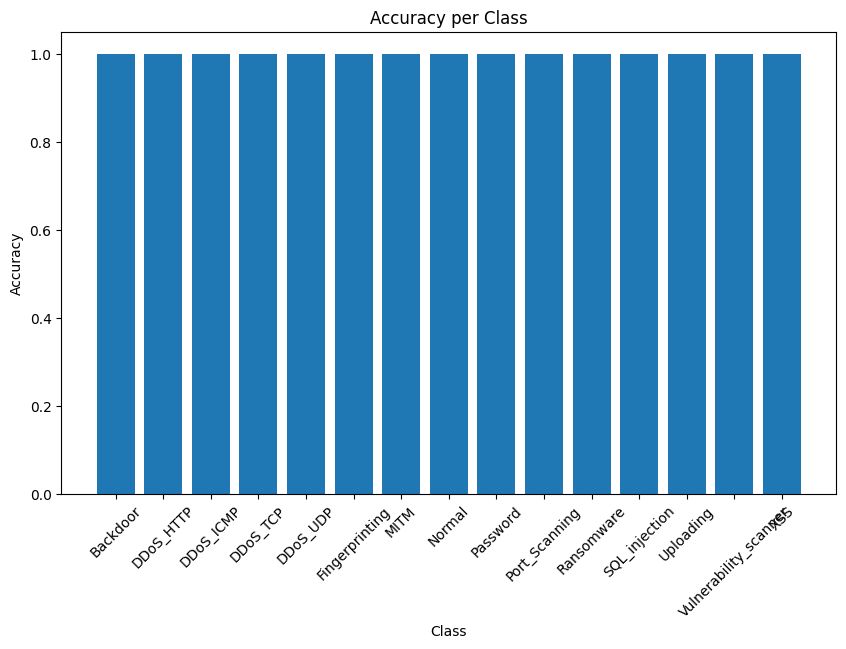

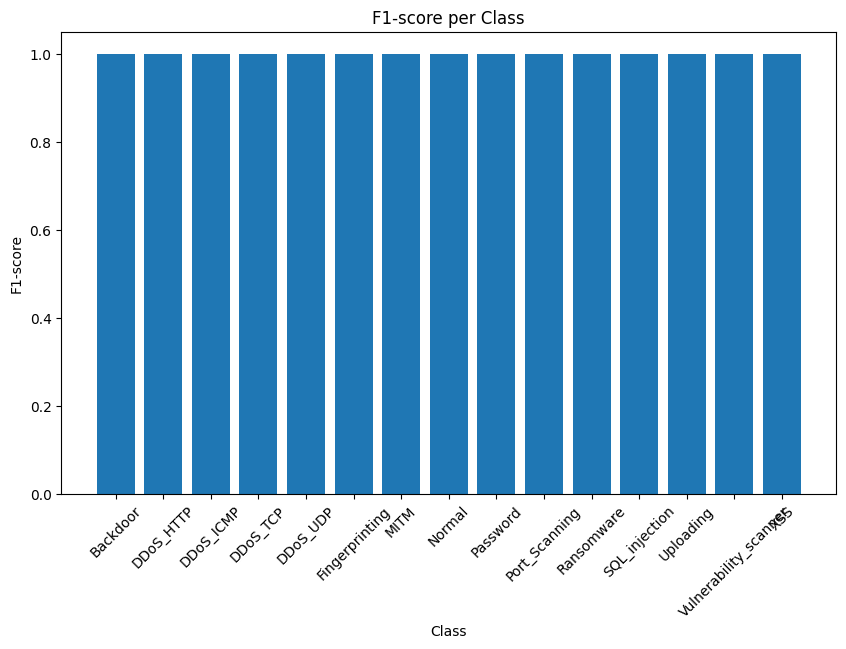

In [ ]:
from sklearn.linear_model import LogisticRegression
# Encode the labels
label_encoder = LabelEncoder()
df['Attack_type'] = label_encoder.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']
# Encode the target variable

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the Logistic Regression Classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train_scaled, y_train)
# Make predictions
y_pred = lr_classifier.predict(X_test_scaled)
# Plot ROC curve
y_score = lr_classifier.predict_proba(X_test_scaled)

model_name = 'LogisticRegression'
plot_roc_curve(y_test, y_score, label_encoder, model_name)
# Print scores
print("LogisticRegression Classifier")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Epoch 1/50
1523/1523 [==============================] - 13s 4ms/step - loss: 0.1413 - accuracy: 0.9600 - val_loss: 0.0452 - val_accuracy: 0.9984
Epoch 2/50
1523/1523 [==============================] - 6s 4ms/step - loss: 0.0159 - accuracy: 0.9961 - val_loss: 0.0356 - val_accuracy: 0.9998
Epoch 3/50
1523/1523 [==============================] - 7s 4ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0417 - val_accuracy: 0.9999
Epoch 4/50
1523/1523 [==============================] - 6s 4ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0375 - val_accuracy: 0.9999
Epoch 5/50
1523/1523 [==============================] - 7s 5ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0472 - val_accuracy: 0.9999
Epoch 6/50
1523/1523 [==============================] - 6s 4ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0694 - val_accuracy: 0.9999
Epoch 7/50
952/952 [==============================] - 2s 3ms/step - loss: 2.6299e-04 - accuracy: 0.9999
Test loss: 0.000262985326116904

,Metric,Value
0,Accuracy,0.999934
1,Precision (macro),0.999930
2,Recall (macro),0.999934
3,F1-score (macro),0.999932
4,AUC-ROC (macro),1.000000
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),1.000000
7,F1-score (Backdoor),1.000000
8,Precision (DDoS_HTTP),1.000000
9,Recall (DDoS_HTTP),1.000000


Number of classes: 15
Shape of y_score: (30447, 15)


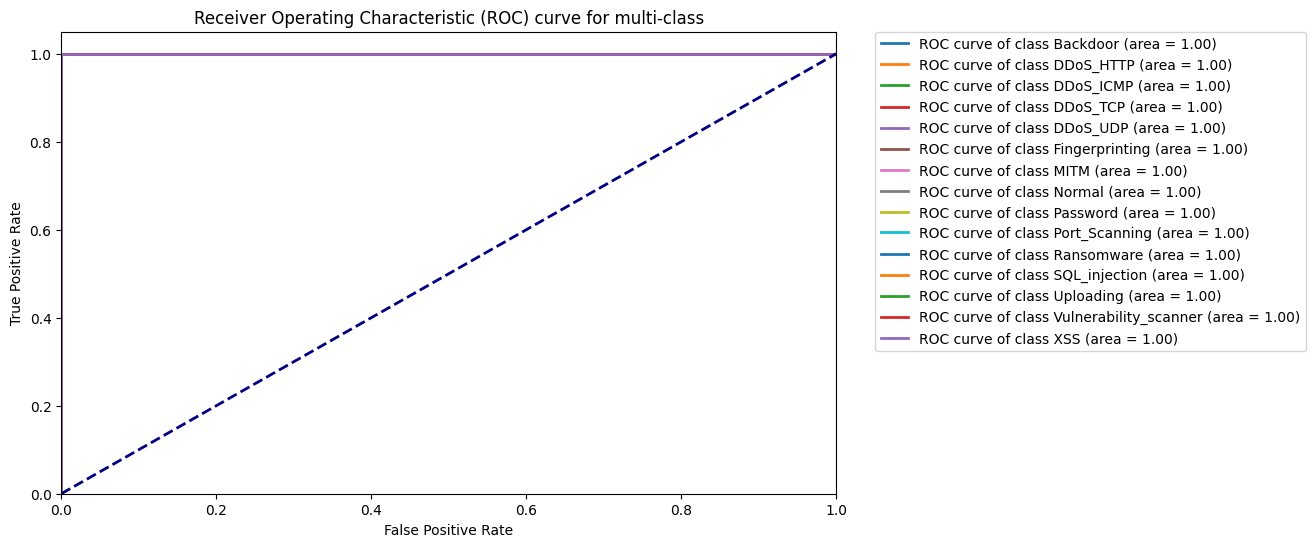

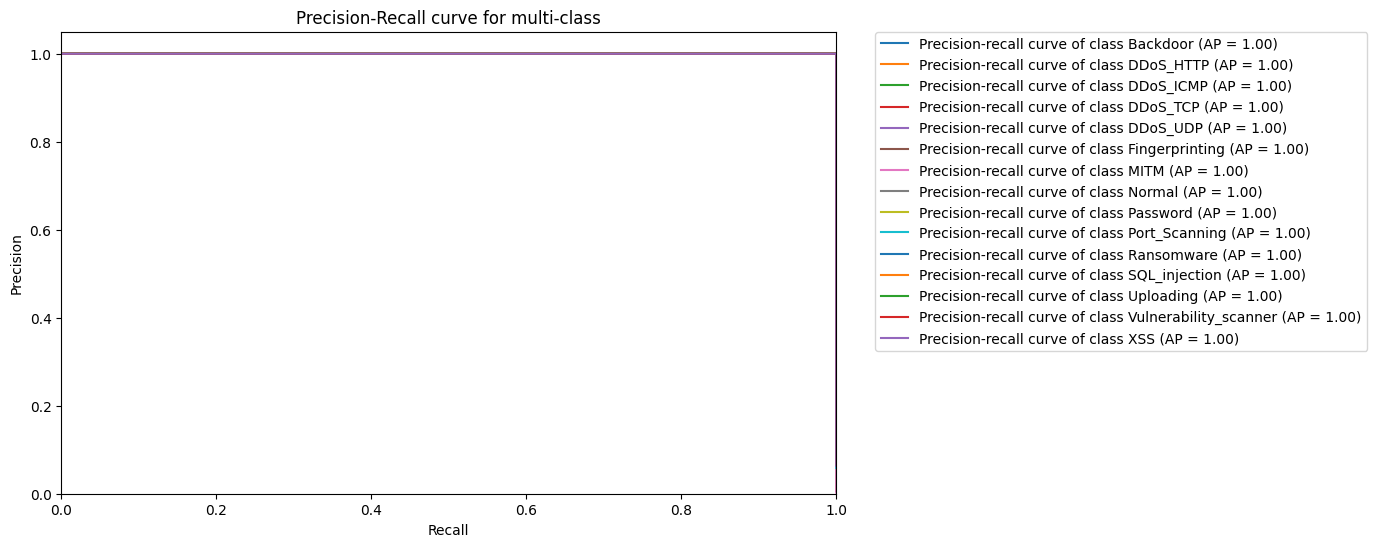

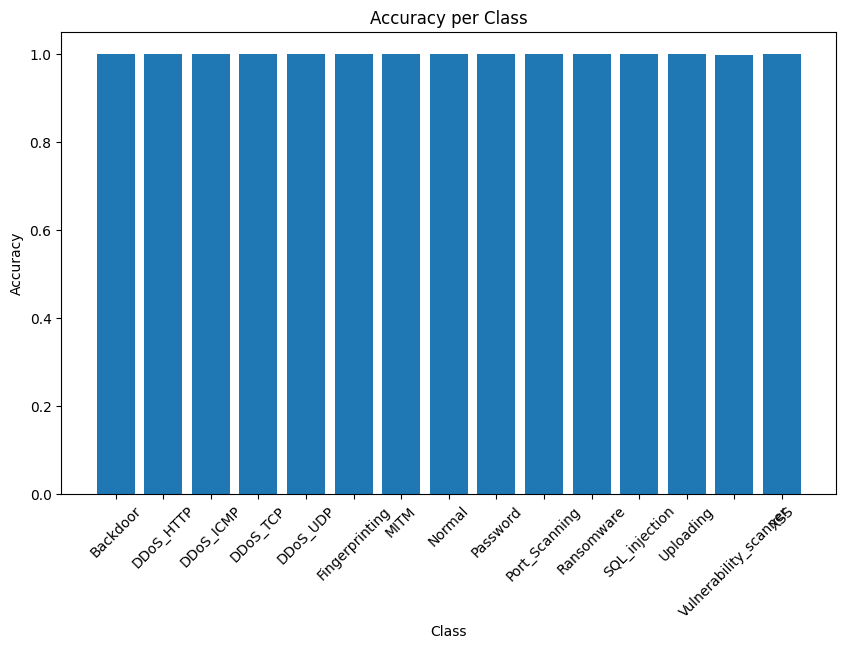

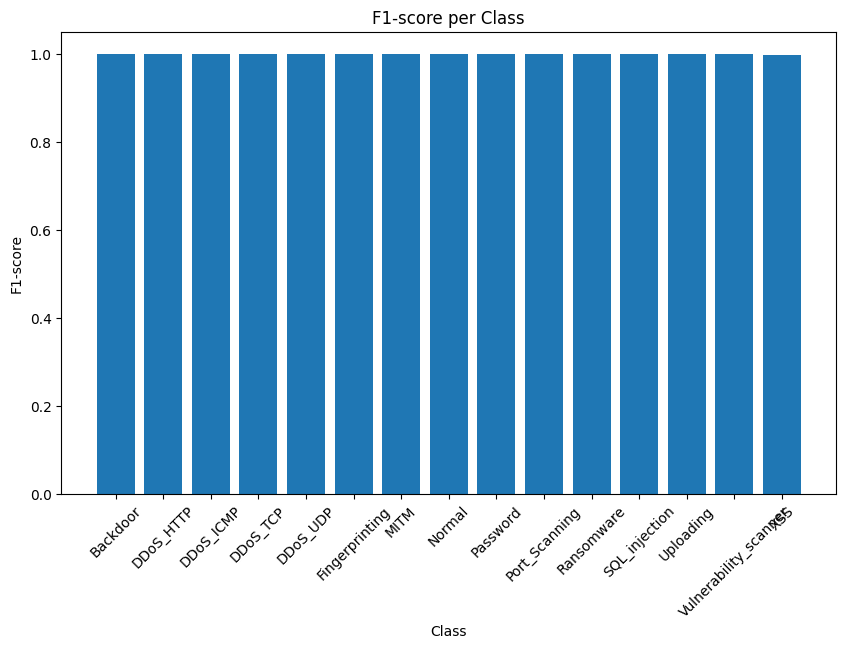

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Encode the labels
label_encoder = LabelEncoder()
df['Attack_type'] = label_encoder.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data into 3D format for use with Conv1D (samples, timesteps, features)
X_train_scaled_3d = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_3d = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


# Define the CNN architecture
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled_3d.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# One-hot encode the training and test labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Then use these one-hot encoded labels to train and evaluate the model
model.fit(X_train_scaled_3d, y_train_encoded, batch_size=64, epochs=50, validation_split=0.2,  callbacks=[early_stopping])

score = model.evaluate(X_test_scaled_3d, y_test_encoded)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Calculate prediction probabilities
y_score = model.predict(X_test_scaled_3d)
y_pred = np.argmax(y_score, axis=-1)
# Convert one-hot encoded y_test_encoded to class labels
y_test_labels = np.argmax(y_test_encoded, axis=-1)
model_name = "CNN"
# Print scores
print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)
plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test_labels, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test_labels, y_pred, label_encoder, model_name)

Epoch 1/100
1333/1333 [==============================] - 11s 7ms/step - loss: 0.7455 - accuracy: 0.7301 - val_loss: 0.1587 - val_accuracy: 0.9674
Epoch 2/100
1333/1333 [==============================] - 8s 6ms/step - loss: 0.2872 - accuracy: 0.8948 - val_loss: 0.0756 - val_accuracy: 0.9854
Epoch 3/100
1333/1333 [==============================] - 8s 6ms/step - loss: 0.1836 - accuracy: 0.9385 - val_loss: 0.0510 - val_accuracy: 0.9937
Epoch 4/100
1333/1333 [==============================] - 9s 6ms/step - loss: 0.1337 - accuracy: 0.9566 - val_loss: 0.0345 - val_accuracy: 0.9984
Epoch 5/100
1333/1333 [==============================] - 8s 6ms/step - loss: 0.1102 - accuracy: 0.9649 - val_loss: 0.0334 - val_accuracy: 0.9994
Epoch 6/100
1333/1333 [==============================] - 9s 7ms/step - loss: 0.0952 - accuracy: 0.9691 - val_loss: 0.0330 - val_accuracy: 0.9997
Epoch 7/100
1333/1333 [==============================] - 8s 6ms/step - loss: 0.0856 - accuracy: 0.9728 - val_loss: 0.0255 - val_a

,Metric,Value
0,Accuracy,0.999628
1,Precision (macro),0.993110
2,Recall (macro),0.998897
3,F1-score (macro),0.995853
4,AUC-ROC (macro),0.999575
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),0.999662
7,F1-score (Backdoor),0.999831
8,Precision (DDoS_HTTP),1.000000
9,Recall (DDoS_HTTP),1.000000


Number of classes: 15
Shape of y_score: (45670, 15)


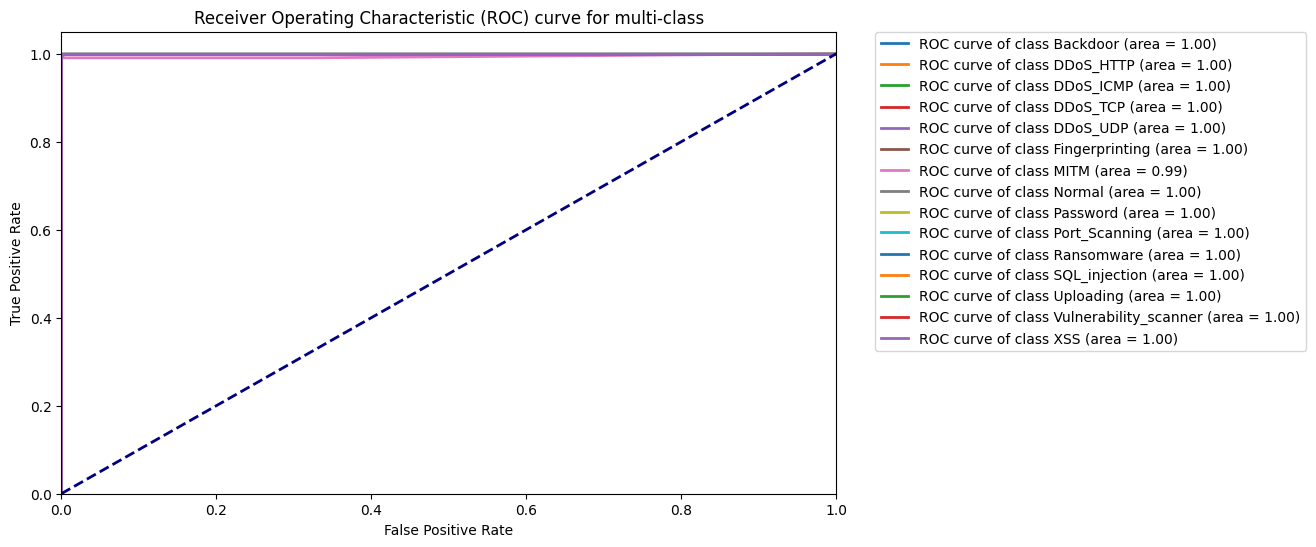

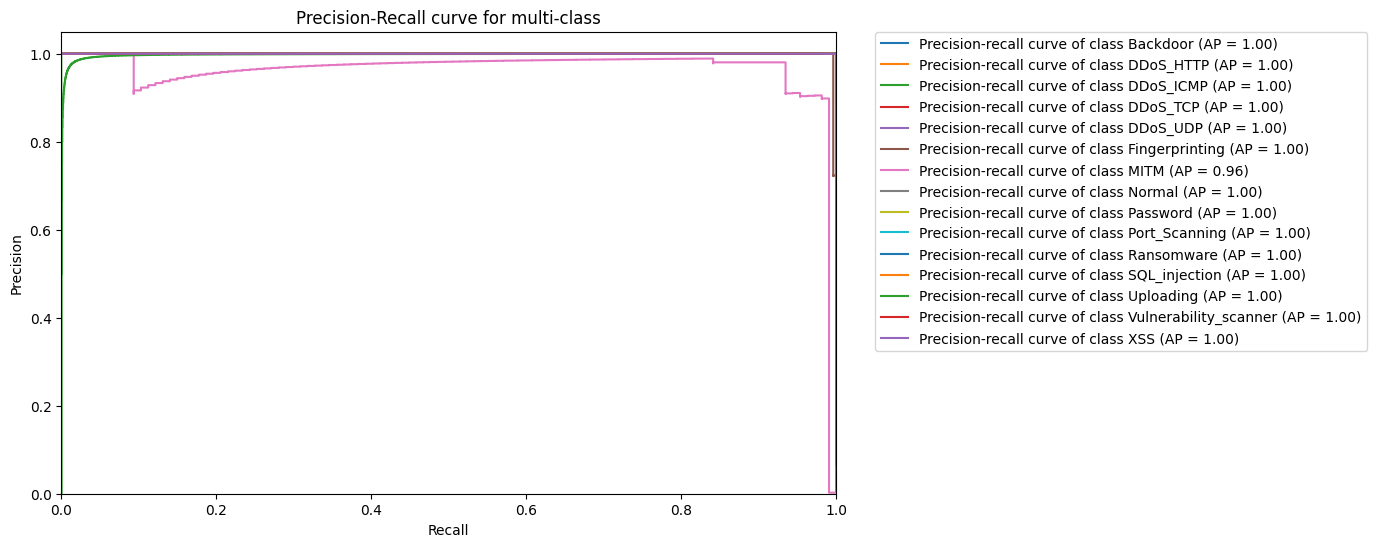

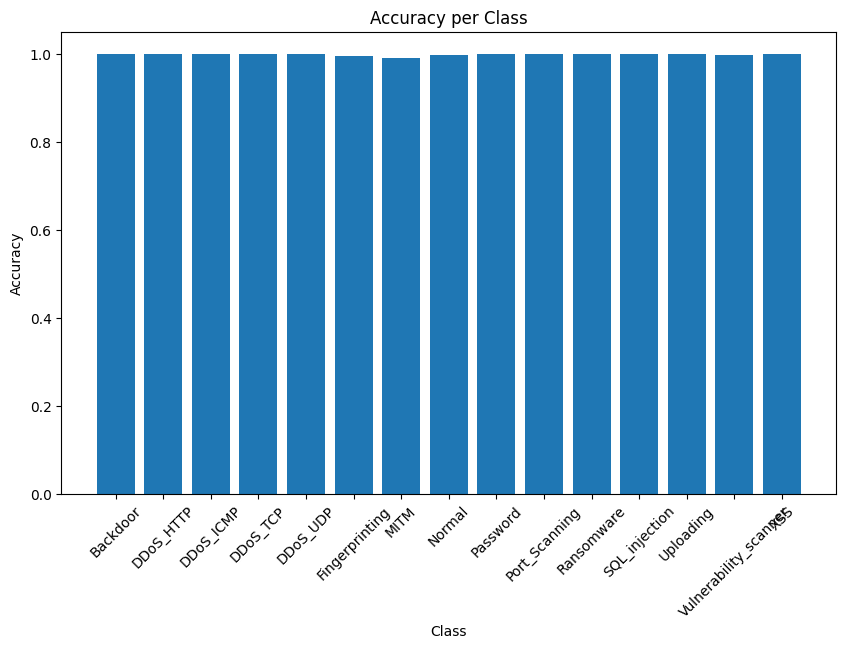

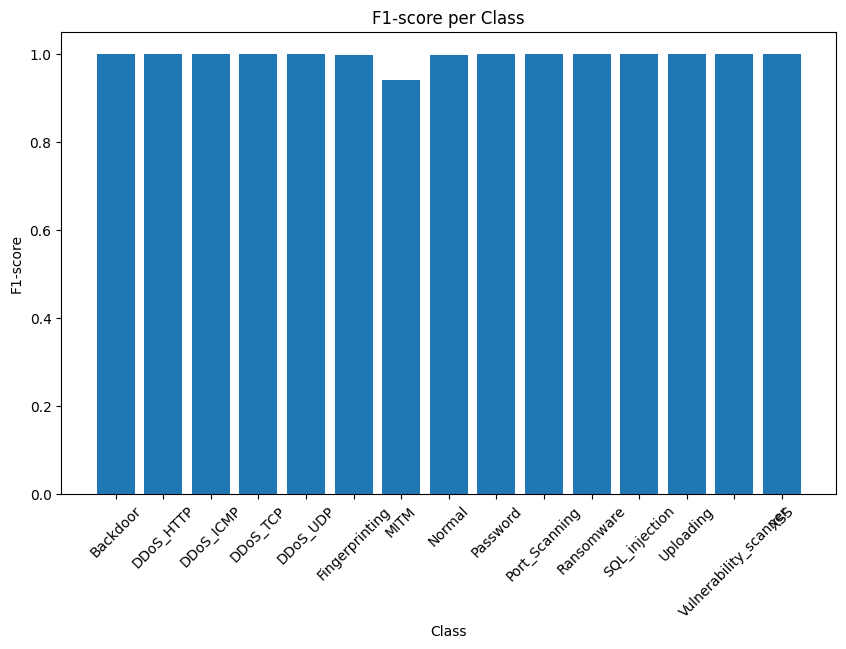

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


model_name = 'LSTM'

# Encode the labels
label_encoder = LabelEncoder()
df['Attack_type'] = label_encoder.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']


# One-hot encode the target variable for use with a CNN
y_onehot = to_categorical(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42,  stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Reshape the input data into 3D format for use with LSTM (samples, timesteps, features)
# Ensure that the data is reshaped appropriately for a time series dataset
timesteps = 1  # Modify this value based on the dataset's structure
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1])

# Define the LSTM architecture
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(timesteps, X_train_scaled.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# Train the model
model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])


# Make predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# Calculate prediction probabilities
y_score = model.predict(X_test_scaled)

# Convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test, axis=-1)

# Print scores
print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)
plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test_labels, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test_labels, y_pred, label_encoder, model_name)

Number of classes: 15
Shape of y_score: (30447, 15)


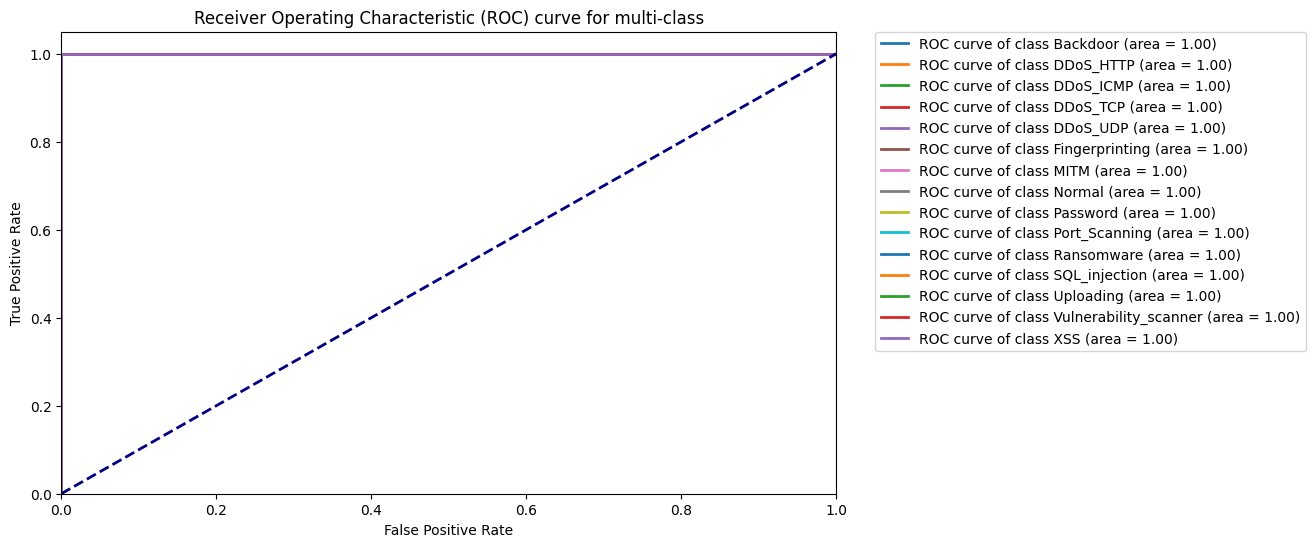

SVM 


,Metric,Value
0,Accuracy,0.999869
1,Precision (macro),0.999924
2,Recall (macro),0.999861
3,F1-score (macro),0.999892
4,AUC-ROC (macro),1.000000
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),0.999493
7,F1-score (Backdoor),0.999747
8,Precision (DDoS_HTTP),1.000000
9,Recall (DDoS_HTTP),1.000000


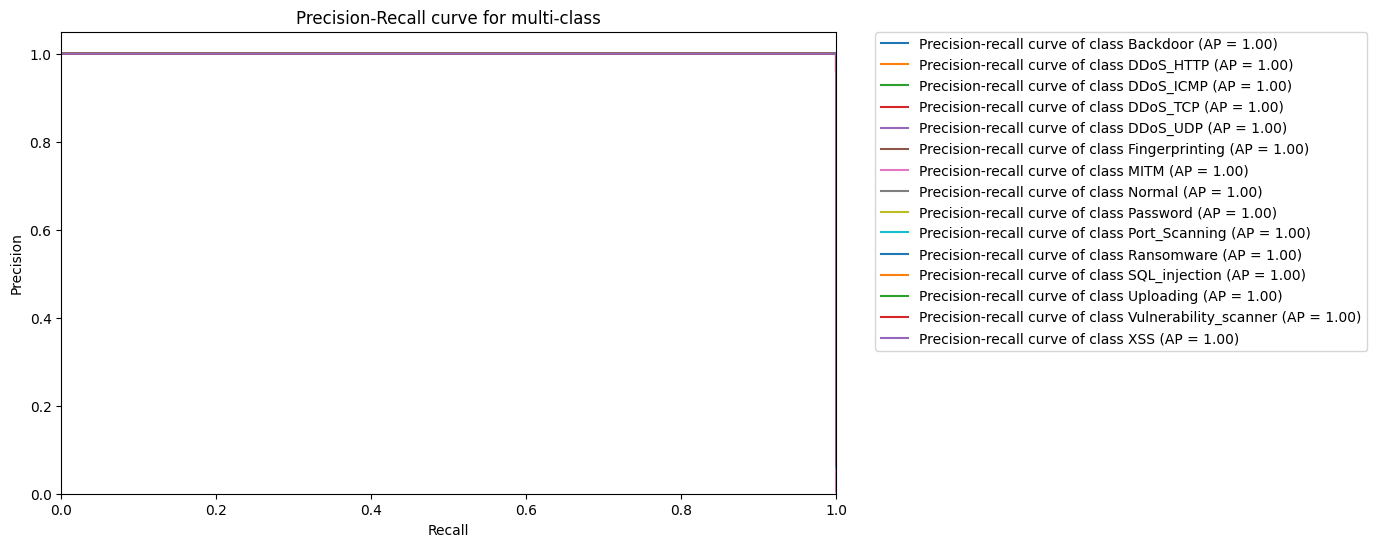

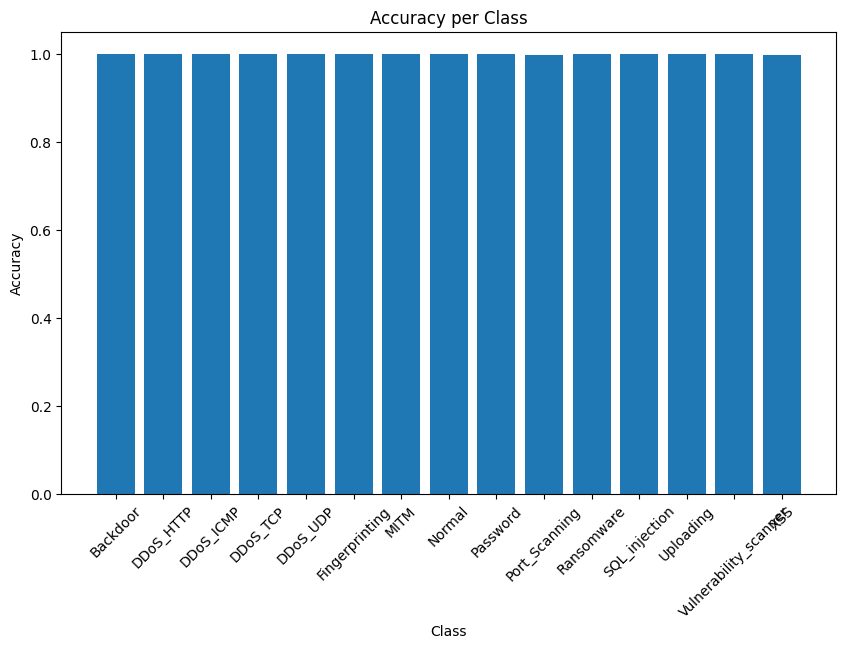

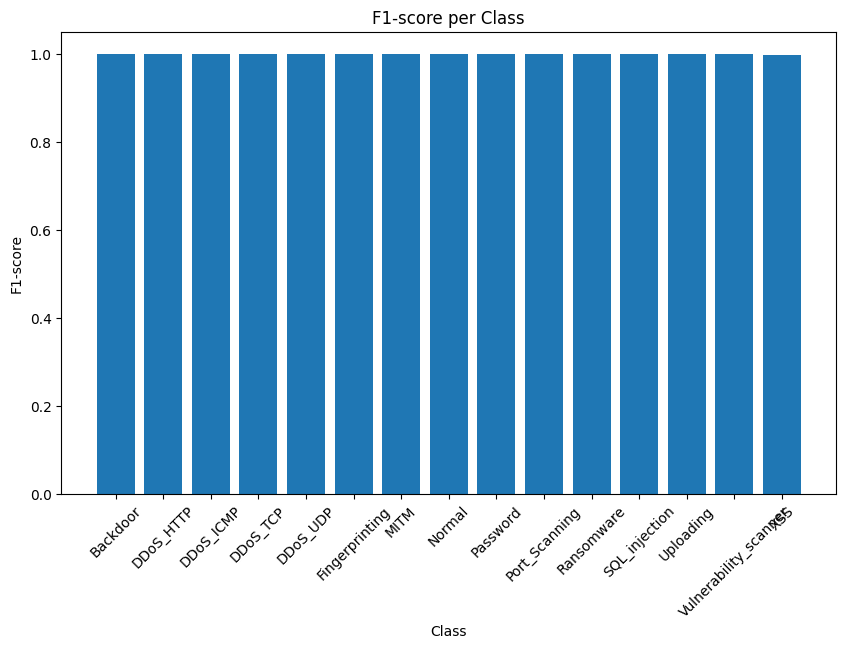

In [ ]:
from sklearn.svm import SVC

# Encode the labels
label_encoder = LabelEncoder()
df['Attack_type'] = label_encoder.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']
# Encode the target variable

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the SVM Classifier
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_scaled)

# Plot ROC curve
y_score = svm_classifier.predict_proba(X_test_scaled)

model_name = 'SVM'
plot_roc_curve(y_test, y_score, label_encoder, model_name)
# Print scores
print("SVM ")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 15
Shape of y_score: (45670, 15)


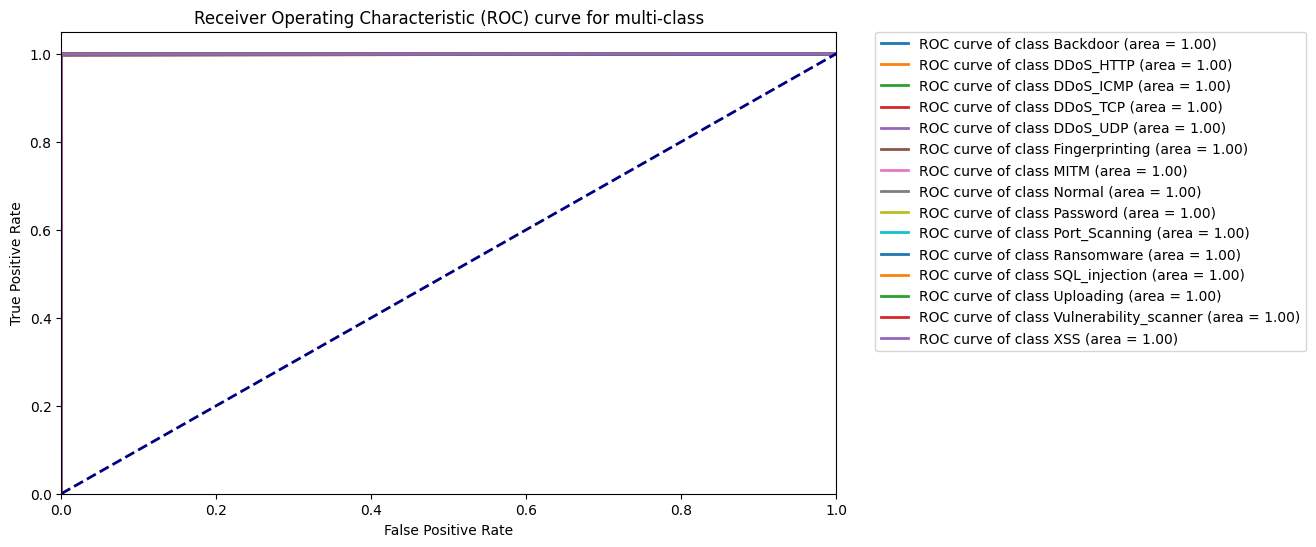

KNN 


,Metric,Value
0,Accuracy,0.999409
1,Precision (macro),0.999154
2,Recall (macro),0.999161
3,F1-score (macro),0.999158
4,AUC-ROC (macro),0.999822
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),0.999662
7,F1-score (Backdoor),0.999831
8,Precision (DDoS_HTTP),1.000000
9,Recall (DDoS_HTTP),1.000000


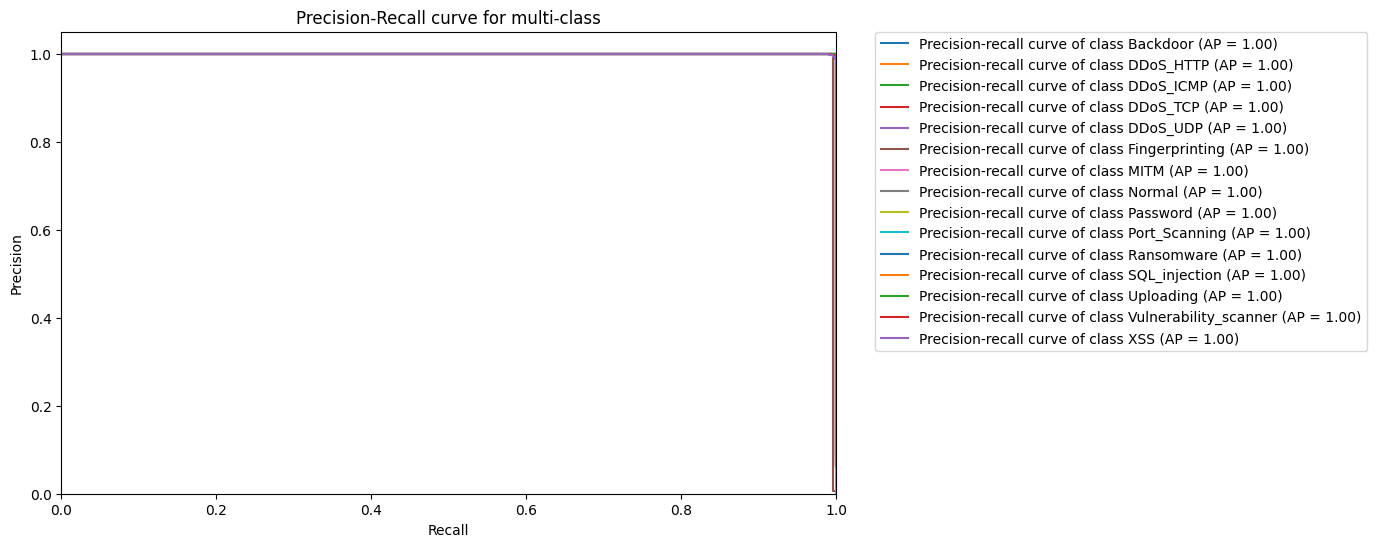

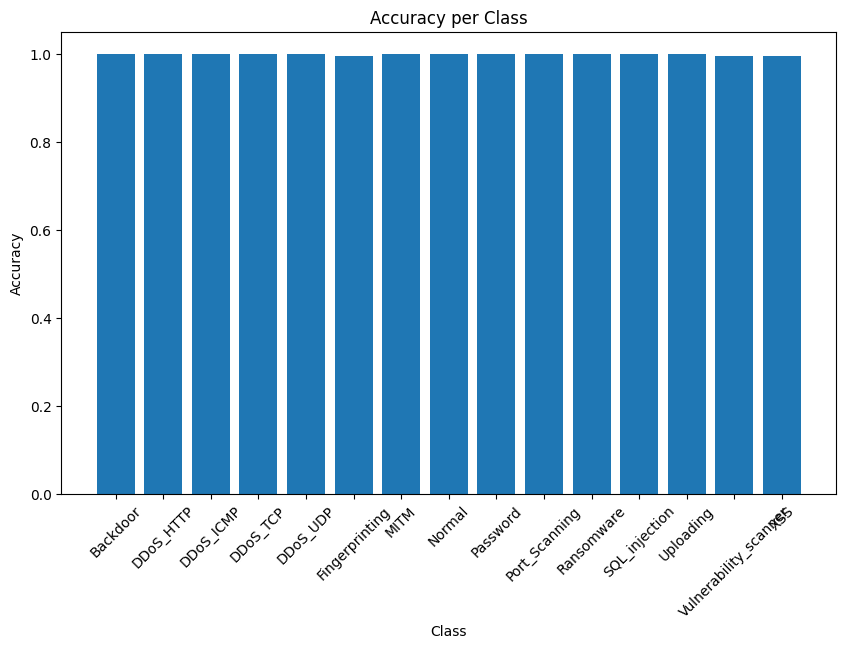

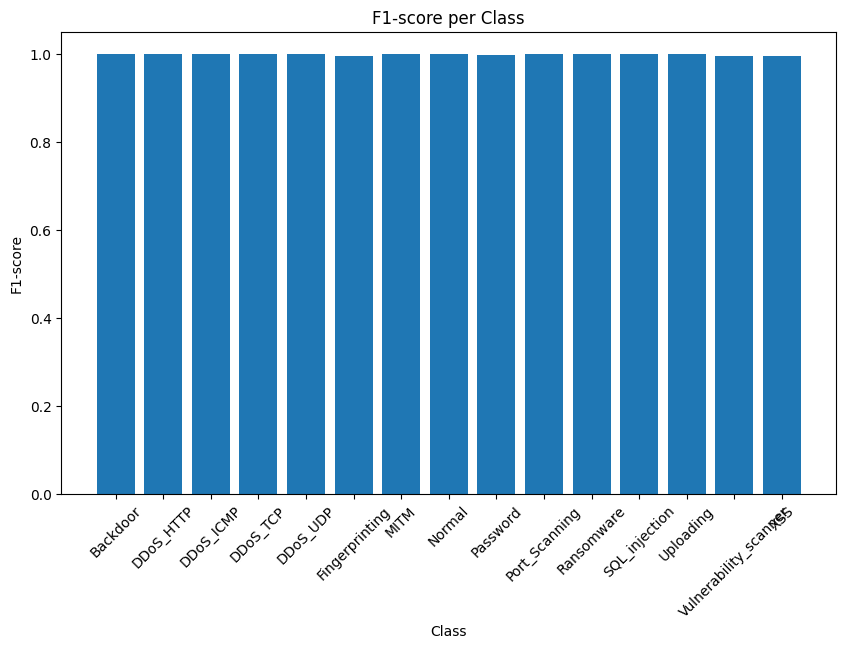

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Encode the labels
label_encoder = LabelEncoder()
df['Attack_type'] = label_encoder.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']
# Encode the target variable


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn_classifier.predict(X_test_scaled)

# Plot ROC curve
y_score = knn_classifier.predict_proba(X_test_scaled)
model_name = 'KNN'
plot_roc_curve(y_test, y_score, label_encoder, model_name)

print("KNN ")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 15
Shape of y_score: (45670, 15)


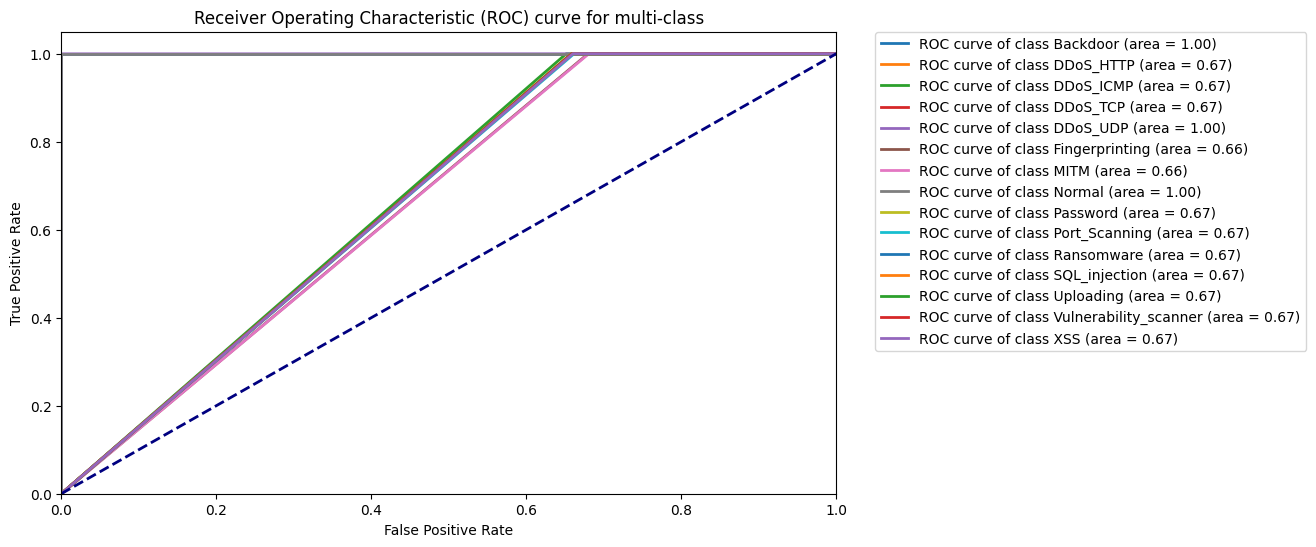

Adaboost 


,Metric,Value
0,Accuracy,0.404511
1,Precision (macro),0.941749
2,Recall (macro),0.266651
3,F1-score (macro),0.214937
4,AUC-ROC (macro),0.735140
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),1.000000
7,F1-score (Backdoor),1.000000
8,Precision (DDoS_HTTP),1.000000
9,Recall (DDoS_HTTP),0.000000


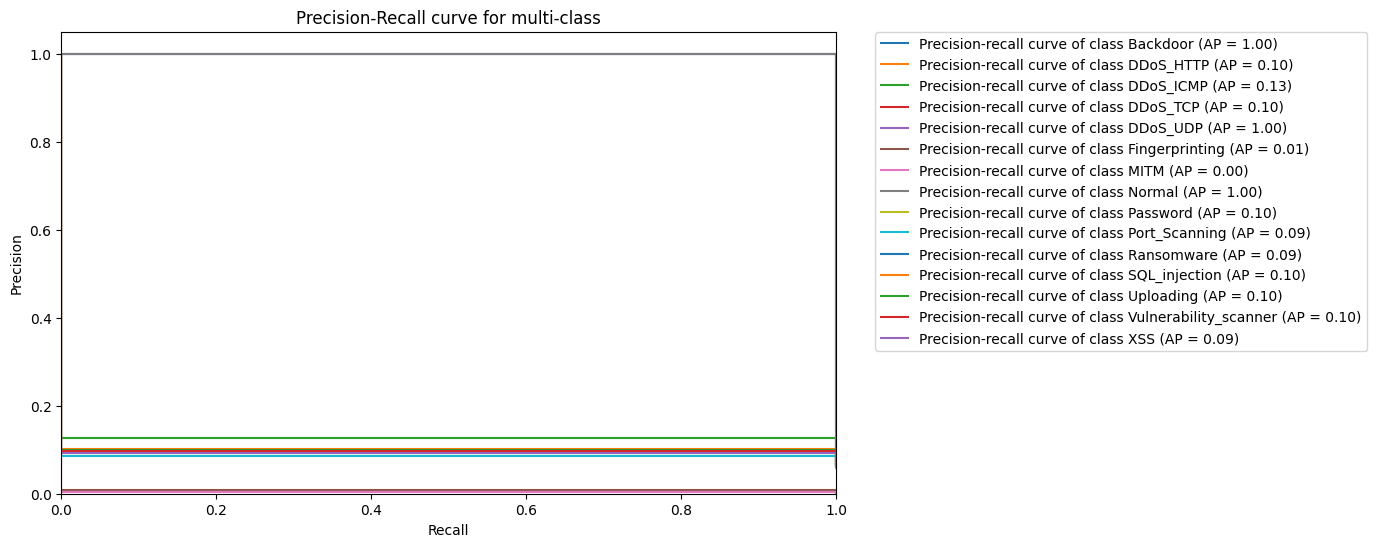

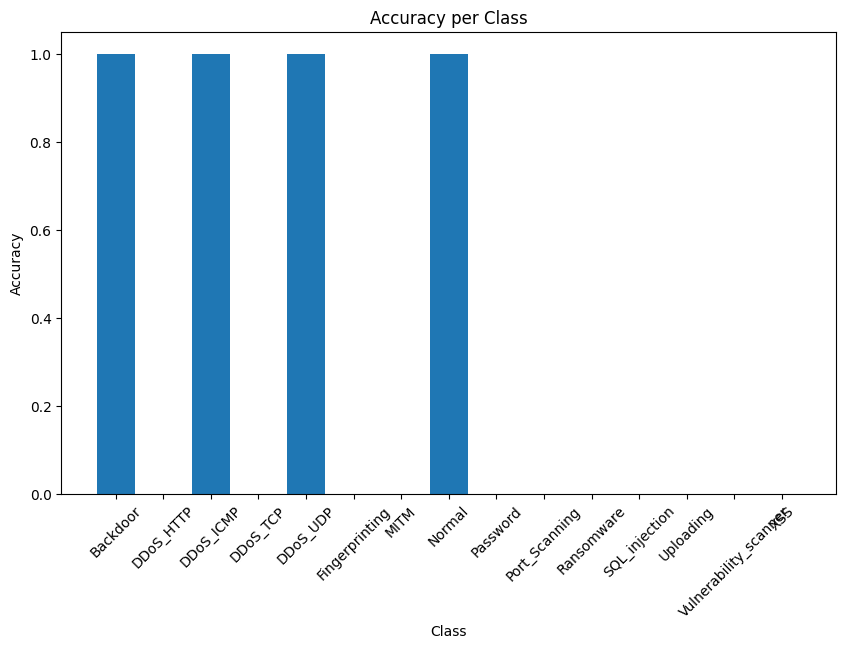

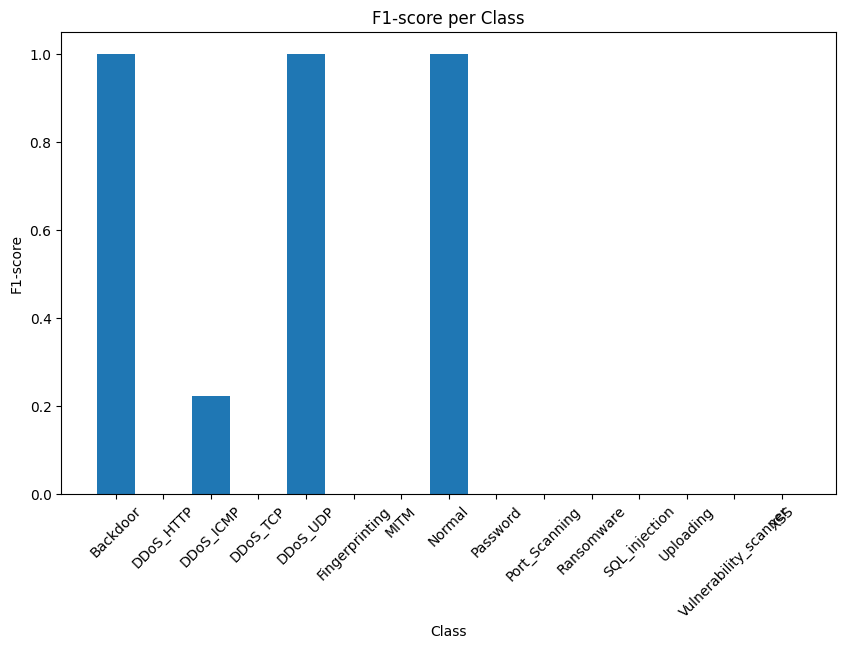

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Train the AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(random_state=42)
adaboost_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = adaboost_classifier.predict(X_test_scaled)

# Plot ROC curve
y_score = adaboost_classifier.predict_proba(X_test_scaled)
model_name = 'Adaboost'
plot_roc_curve(y_test, y_score, label_encoder, model_name)

print("Adaboost ")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 15
Shape of y_score: (45670, 15)


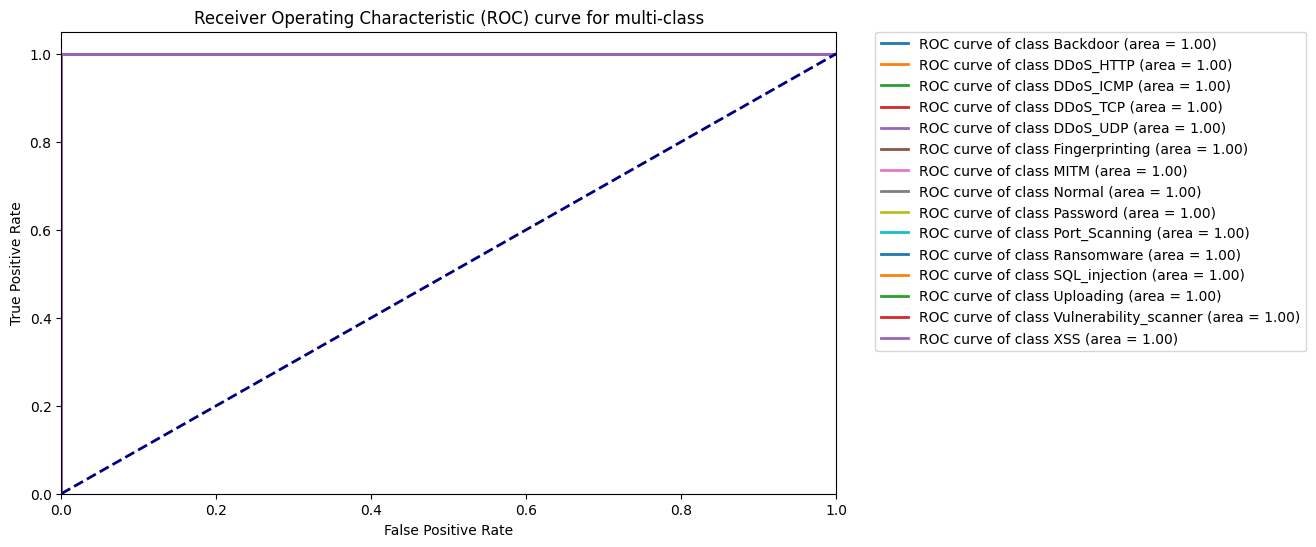

Random Forest Classifier


,Metric,Value
0,Accuracy,1.0
1,Precision (macro),1.0
2,Recall (macro),1.0
3,F1-score (macro),1.0
4,AUC-ROC (macro),1.0
5,Precision (Backdoor),1.0
6,Recall (Backdoor),1.0
7,F1-score (Backdoor),1.0
8,Precision (DDoS_HTTP),1.0
9,Recall (DDoS_HTTP),1.0


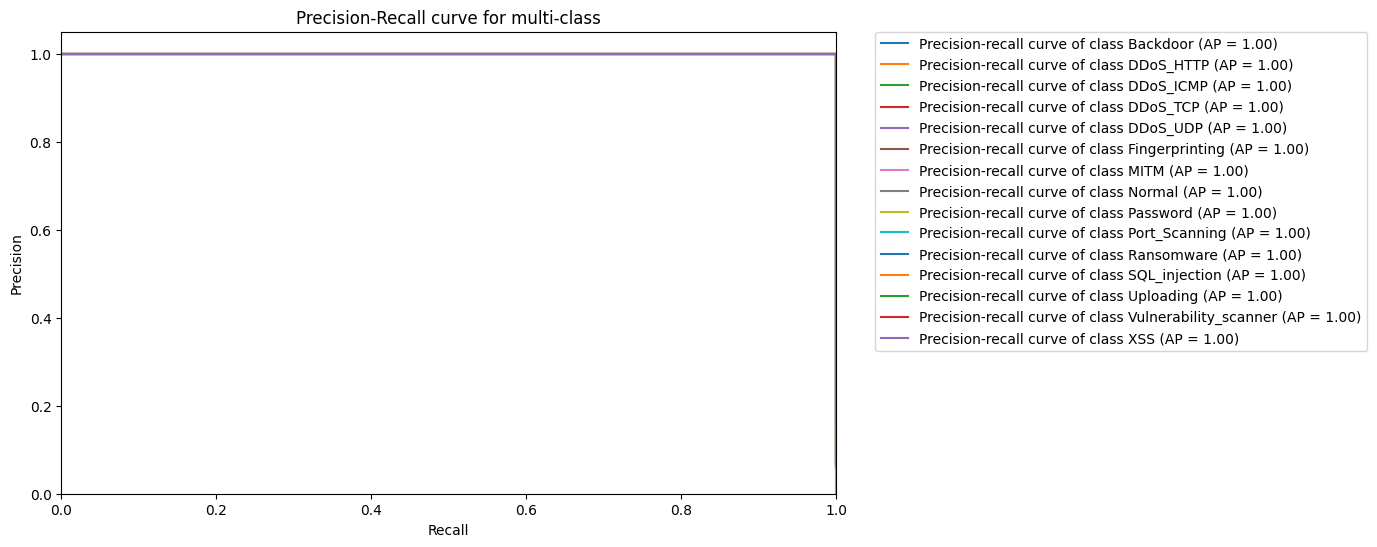

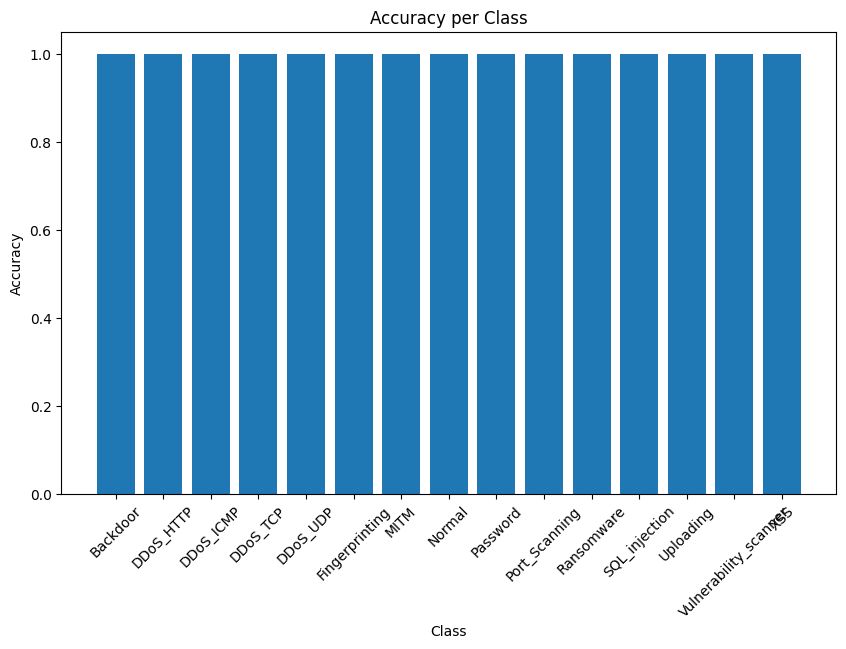

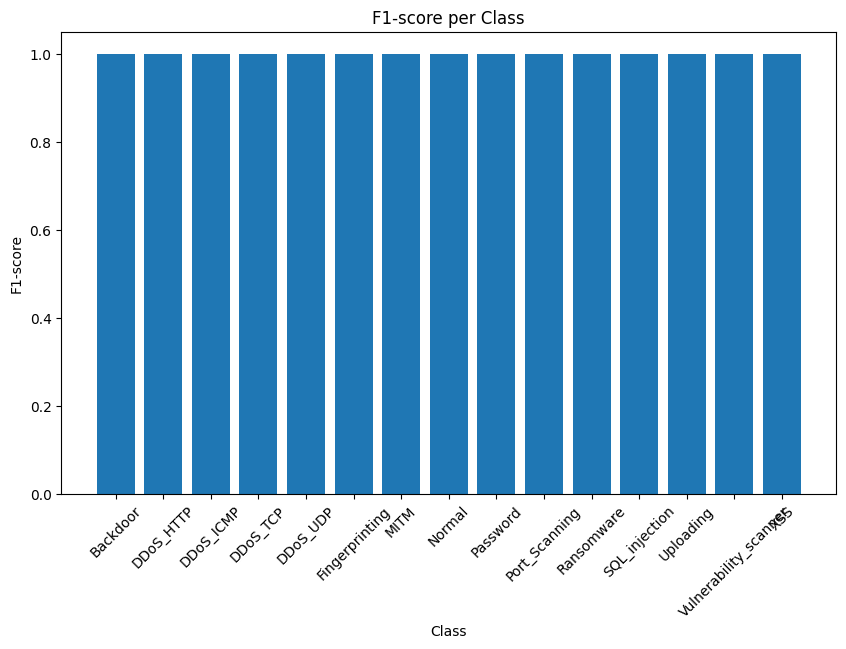

In [ ]:
# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Plot ROC curve
y_score = rf_classifier.predict_proba(X_test_scaled)

model_name = 'RandomForest'
plot_roc_curve(y_test, y_score, label_encoder, model_name)
# Print scores
print("Random Forest Classifier")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

In [ ]:
import tensorflow as tf

embedding_size = 128  # Choose the desired embedding size
X = df.iloc[:, :-1]  # Get all columns except the last one as input features
num_features = X.shape[1]
num_samples = X.shape[0]  # Get the number of samples

# Define the input and embedding layer
input_features = tf.keras.layers.Input(shape=(num_features,))
embedding_layer = tf.keras.layers.Dense(embedding_size, activation='relu')
embeddings = embedding_layer(input_features)

# Positional encoding functions
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    pos_encoding = np.zeros((position, d_model), dtype=np.float32)
    pos_encoding[0::2, :] = np.sin(angle_rads[0::2, :])
    pos_encoding[1::2, :] = np.cos(angle_rads[1::2, :])
    return tf.cast(pos_encoding, dtype=tf.float32)

# Add positional encoding to the embeddings
position = num_features  # Number of positions equal to the number of samples
embeddings_with_pos_enc = positional_encoding(position, embedding_size) + embeddings

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


def position_wise_feed_forward(inputs, d_ff):
    x = Dense(units=d_ff, activation='relu')(inputs)
    x = Dense(units=d_model)(x)
    return x

def multi_head_self_attention(inputs, d_model, num_heads, dropout_rate):
    depth = d_model // num_heads
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=depth, dropout=0.15)
    x = attention(inputs, inputs)
    return x

def encoder_layer(inputs, d_model, num_heads, d_ff, dropout_rate=0.15):
    x = multi_head_self_attention(inputs, d_model, num_heads, dropout_rate)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    ff = position_wise_feed_forward(x, d_ff)
    x = Dropout(dropout_rate)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    return x

class BroadcastPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(BroadcastPositionalEncoding, self).__init__()
        self.pos_encoding = positional_encoding(position, d_model)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.pos_encoding[:shape[0], :shape[1]]

def create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes, dropout_rate=0.15):
    inputs = Input(shape=input_shape)

    # Embedding layer
    embedding_layer = Dense(d_model, activation='relu')
    embeddings = embedding_layer(inputs)

    # Reshape the embeddings to be 3D tensor.
    x = tf.expand_dims(embeddings, axis=1)

    # Broadcast Positional Encoding
    x = BroadcastPositionalEncoding(input_shape[0], d_model)(x) # Apply it on 'x', not 'embeddings'


    # Encoder layers
    for _ in range(num_layers):
        x = encoder_layer(x, d_model, num_heads, d_ff, dropout_rate)

    # Apply GlobalAveragePooling1D
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    # Final softmax layer to predict num_classes
    outputs = Dense(units=num_classes)(x)  # Corrected here
    print("Shape of model output before softmax: ", outputs.shape)
    outputs = tf.keras.layers.Softmax(axis=-1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# Encode the labels
le = LabelEncoder()
df['Attack_type'] = le.fit_transform(df['Attack_type'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['Attack_type']

# Apply feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure there are no missing or corrupted values in input data (X)
assert not np.isnan(X).any(), "X contains NaN values"
assert not np.isinf(X).any(), "X contains infinite values"

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Ensure labels (y_train and y_test) are integer-encoded
assert np.issubdtype(y_train.dtype, np.integer), "y_train should contain integer values"
assert np.issubdtype(y_test.dtype, np.integer), "y_test should contain integer values"

# Ensure there are no missing or corrupted values in input data (X_train and X_test)
# assert not X_train.isnull().values.any(), "X_train contains NaN values"
# assert not X_test.isnull().values.any(), "X_test contains NaN values"
# assert not np.isinf(X_train.values).any(), "X_train contains infinite values"
# assert not np.isinf(X_test.values).any(), "X_test contains infinite values"
# Create and compile the model
input_shape = X.shape[1:]
print("Input Shape for Model: ", input_shape)
d_model = 128  # Select an embedding size for the model
d_ff = 256
num_heads = 4
num_layers = 4
num_classes = len(np.unique(y))
print("Number of classes: ", num_classes)

model = create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the Transformer-based IDS model
batch_size = 64
epochs = 20

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate prediction probabilities
y_score = model.predict(X_test)




Input Shape for Model:  (76,)
Number of classes:  15
Shape of model output before softmax:  (None, 15)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          9856        ['input_2[0][0]']                
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1, 128)       0           ['dense_1[0][0]']                
                                                                                                  
 broadcast_positional_encoding   (None, None, 128)   0           ['tf.expand_dims[0][0]'] 

Number of classes: 15
Shape of y_score: (30447, 15)


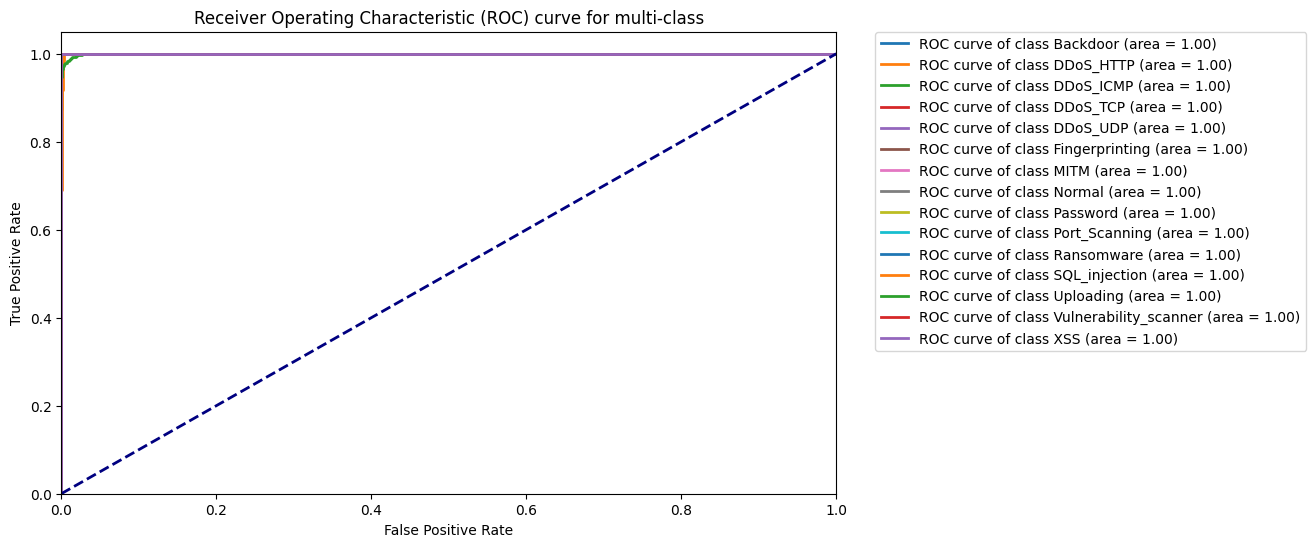

transformer_ids_model 


,Metric,Value
0,Accuracy,0.983906
1,Precision (macro),0.984099
2,Recall (macro),0.942004
3,F1-score (macro),0.951970
4,AUC-ROC (macro),0.999926
5,Precision (Backdoor),1.000000
6,Recall (Backdoor),0.999493
7,F1-score (Backdoor),0.999747
8,Precision (DDoS_HTTP),0.949774
9,Recall (DDoS_HTTP),1.000000


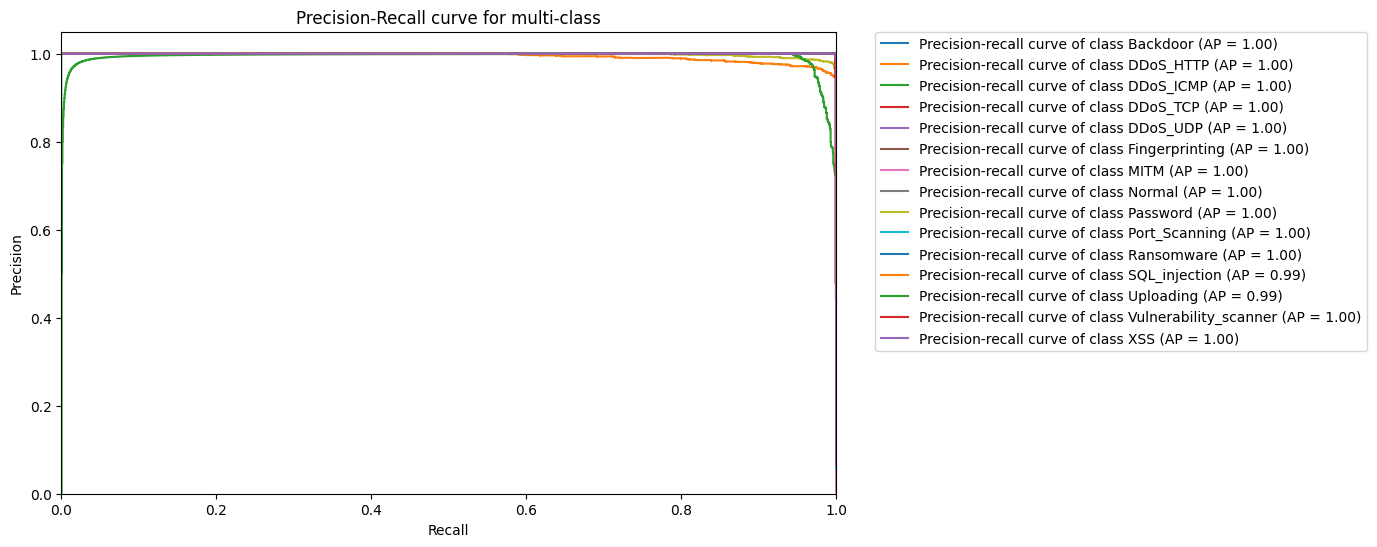

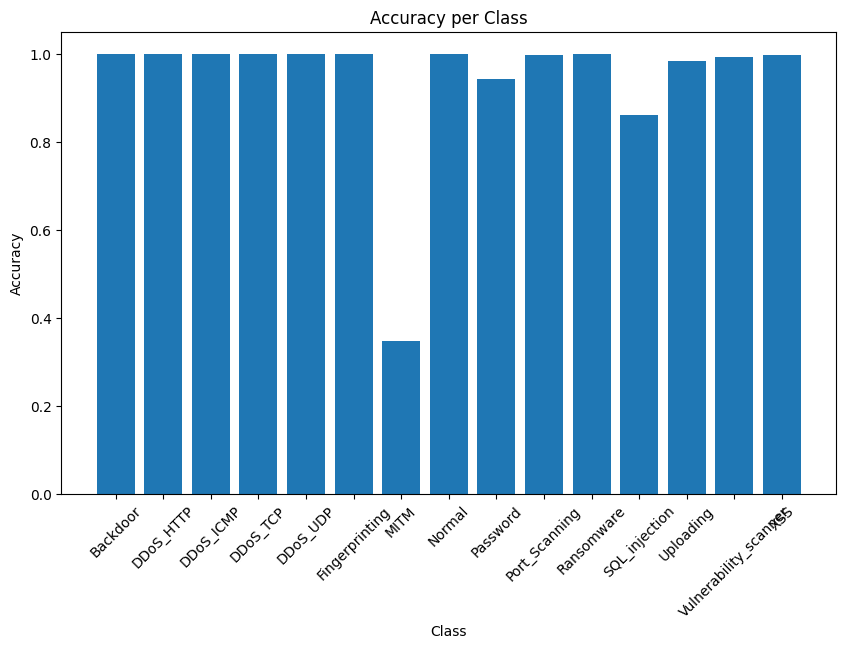

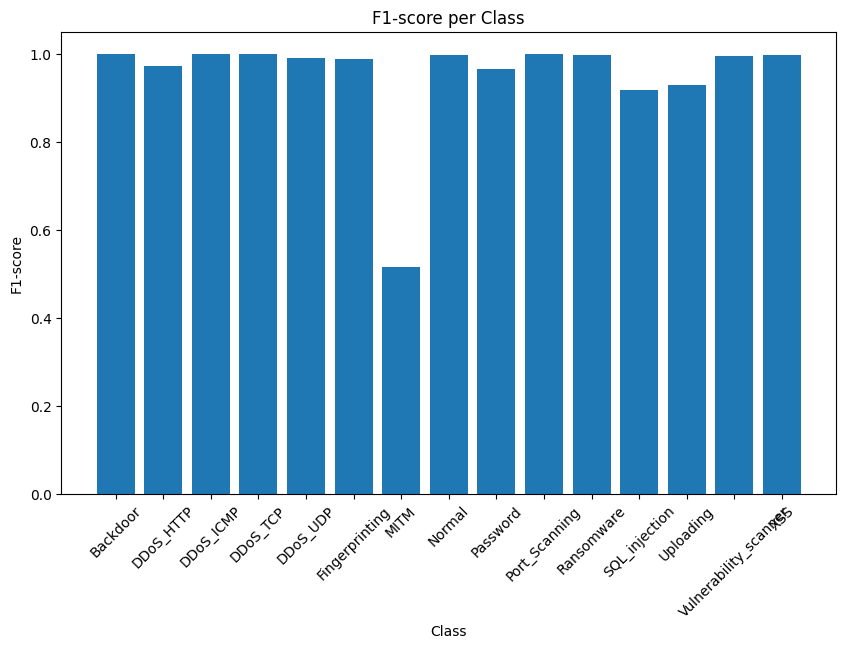

In [ ]:

model_name = 'transformer_ids_model'
plot_roc_curve(y_test, y_score, le, model_name)
# Print scores
print("transformer_ids_model ")
print_score(y_pred, y_test, y_score, le, model_name)
plot_precision_recall_curve(y_test, y_score, le, model_name)
plot_class_accuracy(y_test, y_pred, le, model_name)
plot_class_f1_score(y_test, y_pred, le, model_name)